In [88]:
import healpy as hp
import numpy as np
import matplotlib.pyplot as plt
from plancklens.utils import alm_copy
from delensalot.sims.foregrounds import pointsources as ps

## Apply plancklens on a PS only map

In [89]:
import os
import plancklens
from plancklens import utils
from plancklens.sims import planck2018_sims, phas, maps, utils as maps_utils

from plancklens.filt import filt_simple, filt_util
from plancklens import qest, qecl, qresp
from plancklens.filt import filt_cinv, filt_util

In [167]:
class cmb_len_ffp10:
    """ FFP10 input sim libraries, lensed alms.

        The lensing deflections contain the L=1 aberration term (constant across all maps)
        due to our motion w.r.t. the CMB frame.

    """
    def __init__(self):
        pass

    def hashdict(self):
        return {'sim_lib': 'ffp10 lensed scalar cmb inputs, freq 0'}

    @staticmethod
    def get_sim_tlm(idx):
        """
            Args:
                idx: simulation index

            Returns:
                lensed temperature simulation healpy alm array

        """
        print("Getting simulation")
        return hp.read_alm(f"/Users/omard/Downloads/SCRATCHFOLDER/n32/S4WebskyWebskyBorn/cmbs/sim_{idx:04}_pslm.fits")

In [168]:
#set PLENS os enviorment
os.environ['PLENS'] = '/Users/omard/Downloads/SCRATCHFOLDER/PLENS'

In [169]:
assert 'PLENS' in os.environ.keys(), 'Set env. variable PLENS to a writeable folder'
TEMP =  os.path.join(os.environ['PLENS'], 'temp', 'anisofilt_example')

TEMP_SIMPLE =  os.path.join(os.environ['PLENS'], 'temp_simple', 'anisofilt_example')

TEMP = TEMP_SIMPLE

cls_path = os.path.join(os.path.dirname(os.path.abspath(plancklens.__file__)), 'data', 'cls')

In [270]:
#--- definition of simulation and inverse-variance filtered simulation libraries:
lmax_ivf = 3000
lmin_ivf = 10  # We will use in the QE only CMB modes between lmin_ivf and lmax_ivf
lmax_qlm = 3072 # We will calculate lensing estimates until multipole lmax_qlm.
nside = 1024 # Healpix resolution of the data and sims.
nlev_t = 1. # Filtering noise level in temperature (here also used for the noise simulations generation).
nlev_p = 1.*np.sqrt(2) # Filtering noise level in polarization (here also used for the noise simulations generation).

In [271]:
transf = hp.gauss_beam(1. / 60. / 180. * np.pi, lmax=lmax_ivf) * hp.pixwin(nside)[:lmax_ivf + 1]
#: CMB transfer function. Here a 5' Gaussian beam and healpix pixel window function.

cl_unl = utils.camb_clfile(os.path.join(cls_path, 'FFP10_wdipole_lenspotentialCls.dat'))
cl_len = utils.camb_clfile(os.path.join(cls_path, 'FFP10_wdipole_lensedCls.dat'))
#: Fiducial unlensed and lensed power spectra used for the analysis.

cl_weight = utils.camb_clfile(os.path.join(cls_path, 'FFP10_wdipole_lensedCls.dat'))
cl_weight['bb'] *= 0.


libdir_pixphas = os.path.join(TEMP, 'pix_phas_nside%s'%nside)
pix_phas = phas.pix_lib_phas(libdir_pixphas, 3, (hp.nside2npix(nside),))

In [272]:
nsims = 1

In [273]:
sims = maps_utils.sim_lib_shuffle(maps.cmb_maps_nlev(cmb_len_ffp10(), transf, nlev_t, nlev_p, nside,
                            pix_lib_phas=pix_phas), {idx: nsims if idx == -1 else idx for idx in range(-1, nsims)})

In [274]:
ninv_t = [3. / nlev_t ** 2 *np.ones(hp.nside2npix(nside))]

In [275]:
libdir_cinvt = os.path.join(TEMP, 'cinv_t')

In [276]:
#cinv_t = filt_cinv.cinv_t(libdir_cinvt, lmax_ivf,nside, cl_len, transf, ninv_t,
#                        marge_monopole=True, marge_dipole=True, marge_maps=[])

In [277]:
libdir_ivfs  = os.path.join(TEMP, 'ivfs')

libdir_ivfs_simple  = os.path.join(TEMP, 'libdir_ivfs_simple')

In [278]:
from plancklens.utils import cli

In [279]:
#ftl = np.ones(lmax_ivf + 1, dtype=float) * (np.arange(lmax_ivf + 1) >= lmin_ivf) # rescaling or cuts. Here just a lmin cut
#fel = np.ones(lmax_ivf + 1, dtype=float) * (np.arange(lmax_ivf + 1) >= lmin_ivf)
#fbl = np.ones(lmax_ivf + 1, dtype=float) * (np.arange(lmax_ivf + 1) >= lmin_ivf)

ftl =  cli(cl_len['tt'][:lmax_ivf + 1] + (nlev_t / 180 / 60 * np.pi) ** 2 * cli(transf ** 2)) * (transf > 0)
fel =  cli(cl_len['ee'][:lmax_ivf + 1] + (nlev_p / 180 / 60 * np.pi) ** 2 * cli(transf ** 2)) * (transf > 0)
fbl =  cli(cl_len['bb'][:lmax_ivf + 1] + (nlev_p / 180 / 60 * np.pi) ** 2 * cli(transf ** 2)) * (transf > 0)

#ivfs_raw    = filt_cinv.library_cinv_sepTP(libdir_ivfs, sims, cinv_t, cinv_t, cl_len)
#ivfs   = filt_util.library_ftl(ivfs_raw, lmax_ivf, ftl, fel, fbl)

ivfs = filt_simple.library_fullsky_sepTP(libdir_ivfs_simple, sims, nside, transf, cl_len, ftl, fel, fbl, cache=True)

In [296]:
from plancklens import nhl
nhl_dd = nhl.nhl_lib_simple(os.path.join(TEMP, 'nhl_dd'), ivfs, cl_len, lmax_qlm)

/opt/homebrew/Caskroom/miniforge/base/envs/lenscarf/lib/python3.10/site-packages/plancklens/utils.py:124: RuntimeWarning: overflow encountered in cast
  return hashlib.sha1(np.copy(cl.astype(dtype), order='C')).hexdigest()


In [280]:
fal = {}
fal["tt"] = ftl
fal["ee"] = fel
fal["bb"] = fbl
resplib = qresp.resp_lib_simple(os.path.join(TEMP, 'qlms_dd'), lmax_ivf, cls_weight = cl_len, cls_cmb = cl_len, fal = fal, lmax_qlm = lmax_qlm)

In [281]:
qlms_dd = qest.library_sepTP(os.path.join(TEMP, 'qlms_dd'), ivfs, ivfs,  cl_len['te'], nside, lmax_qlm=lmax_qlm, resplib = resplib)

Caching sky fractions...


In [282]:
#k = "ptt_bh_s"
k = "stt"#_bh_p"
k_bh = "stt_bh_p"
source = "s"

#slm0  = qlms_dd.get_sim_qlm(k, int(0)) 

slm0_bh = qlms_dd.get_sim_qlm(k_bh, int(0))

Getting simulation
Filtering
Transform to map nside 1024


In [298]:
Noise = nhl.get_nhl("stt", "stt", cl_len, fal, lmax_ivf, lmax_ivf, lmax_out=lmax_qlm)

In [284]:
Rs = qresp.get_response(k, lmax_ivf, source, cls_weight = cl_len, cls_cmb = cl_len, fal = {'e': fel, 'b': fbl, 't':ftl}, lmax_qlm=lmax_qlm)[0]

Rs_bh = qresp.get_response(k_bh, lmax_ivf, source, cls_weight = cl_len, cls_cmb = cl_len, fal = {'e': fel, 'b': fbl, 't':ftl}, lmax_qlm=lmax_qlm)[0]
Rs_bh

array([1.12246415e+14, 1.06344988e+14, 1.06121014e+14, ...,
       8.04862555e+12, 8.04747615e+12, 8.04638919e+12])

In [285]:
soriginal = cmb_len_ffp10().get_sim_tlm(0)
soriginal[0] = 0
soriginalmappa = hp.alm2map(alm_copy(soriginal, lmax_qlm), nside, lmax = lmax_qlm)

Getting simulation


In [286]:
s2 = soriginalmappa**2.
s2lm = hp.map2alm(s2, lmax = lmax_qlm, iter = 3)

In [287]:
soriginal = alm_copy(soriginal, lmax_qlm)

In [318]:
#sestimated = hp.almxfl(slm0, utils.cli(Rs))
sestimated_bh = hp.almxfl(slm0_bh, utils.cli(Rs_bh))

In [319]:
#sestimated_bh = slm0_bh

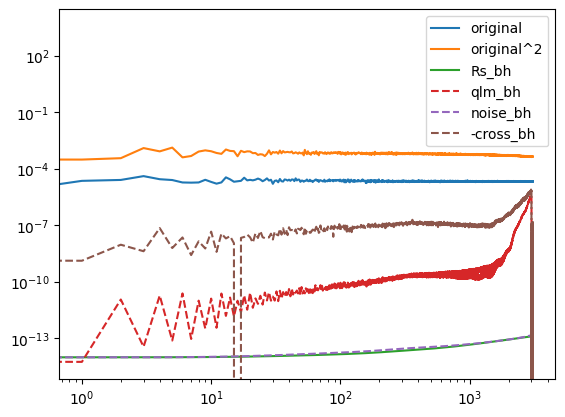

In [320]:
plt.plot(hp.alm2cl(soriginal), label = "original")
plt.plot(hp.alm2cl(s2lm), label = "original^2")
plt.plot(utils.cli(Rs_bh), label = "Rs_bh")

#plt.plot(hp.alm2cl(sestimated), label = "qlm")
plt.loglog(hp.alm2cl(sestimated_bh), ls = "--", label = "qlm_bh")

plt.loglog(Noise[0]*cli(Rs_bh)**2, ls = "--", label = "noise_bh")

#plt.loglog(abs(hp.alm2cl(s2lm, sestimated)), label = "cross")
#plt.loglog((hp.alm2cl(aa, sestimated_bh)), ls = "--", label = "fake cross_bh")
plt.loglog(-(hp.alm2cl(s2lm, sestimated_bh)), ls = "--", label = "-cross_bh")

plt.legend()

In [307]:
plmin = hp.read_alm("/Users/omard/Downloads/SCRATCHFOLDER/n32/S4WebskyWebskyBorn/cmbs/sim_0000_plm.fits")
plmin = alm_copy(plmin, lmax = lmax_qlm)

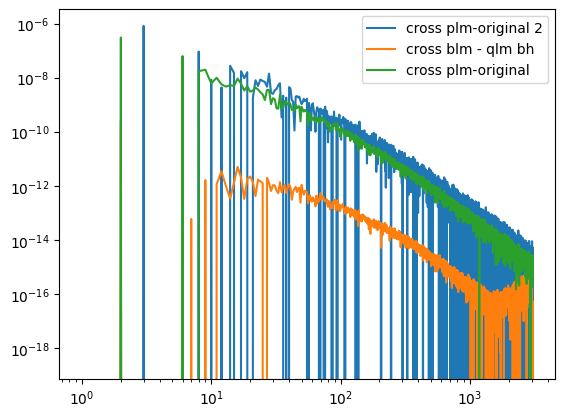

In [310]:
plt.loglog(hp.alm2cl(s2lm, plmin), label = "cross plm-original 2")
plt.loglog(-(hp.alm2cl(sestimated_bh, plmin)), label = "cross blm - qlm bh")
plt.loglog((hp.alm2cl(alm_copy(soriginal, lmax = lmax_qlm), plmin)), label = "cross plm-original")
plt.legend()

Getting simulation
Getting simulation


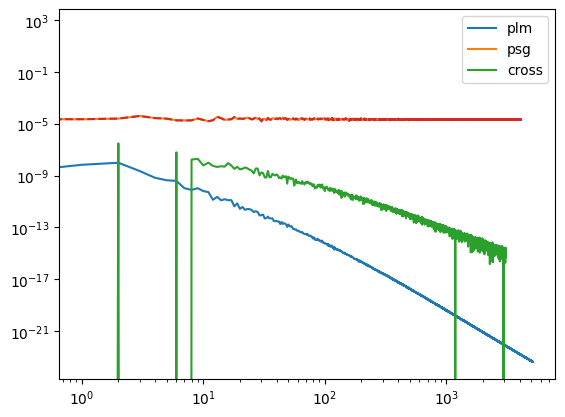

In [247]:
plmin = hp.read_alm("/Users/omard/Downloads/SCRATCHFOLDER/n32/S4WebskyWebskyBorn/cmbs/sim_0000_plm.fits")
psg = hp.read_alm("/Users/omard/Downloads/SCRATCHFOLDER/n32/S4WebskyWebskyBorn/cmbs/sim_0000_pslm.fits")
plt.loglog(hp.alm2cl(plmin), label = "plm") 
plt.loglog(hp.alm2cl(psg), label = "psg")
plt.loglog(hp.alm2cl(alm_copy(plmin, lmax = lmax_qlm),  alm_copy(cmb_len_ffp10().get_sim_tlm(0), lmax = lmax_qlm)), label = "cross")
plt.loglog(hp.alm2cl(cmb_len_ffp10().get_sim_tlm(0)), ls = "--")
plt.legend()


In [13]:
F = ps.Foreground()

In [48]:
tlm = hp.read_alm("/Users/omard/Downloads/SCRATCHFOLDER/n32/S4WebskyWebskyBorn/cmbs/sim_0001_tlm.fits")

In [343]:
pslm = hp.read_alm("/Users/omard/Downloads/SCRATCHFOLDER/n32/S4WebskyWebskyBorn/cmbs/sim_0000_pslm.fits")
pslmrand = hp.read_alm("/Users/omard/Downloads/SCRATCHFOLDER/n32/S4WebskyWebskyBorn/cmbs/sim_0000_psrandlm.fits")

In [344]:
lmax = hp.Alm.getlmax(tlm.size)
lmax

4096

In [377]:
slm = np.load("/Users/omard/Downloads/SCRATCHFOLDER/n32/S4WebskyWebskyBornForegrounds/lenscarfrecs/ptt_bh_s_sim0000/normalized_s_slm_it000.npy")

In [378]:
hp.Alm.getlmax(slm.size)

4500

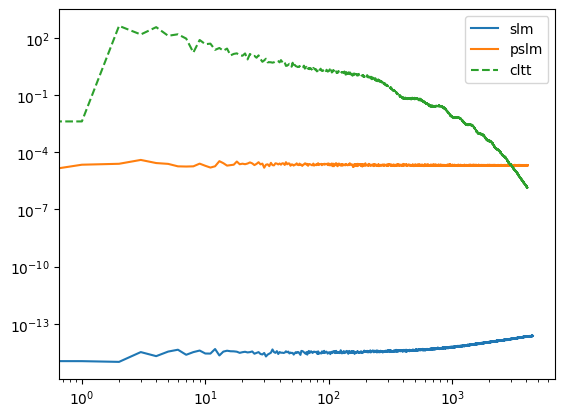

In [379]:
plt.loglog(hp.alm2cl(slm), label = 'slm')
plt.loglog(hp.alm2cl(pslm), label = 'pslm')
plt.loglog(hp.alm2cl(tlm), label = 'cltt', ls = "--")
plt.legend()

In [380]:
pslm[0] = 0
ps = hp.alm2map(pslm, nside = 2048)
ps = ps**2
ps2_lm = hp.map2alm(ps, lmax = hp.Alm.getlmax(pslm.size))

In [381]:
pixwin = hp.pixwin(2048)

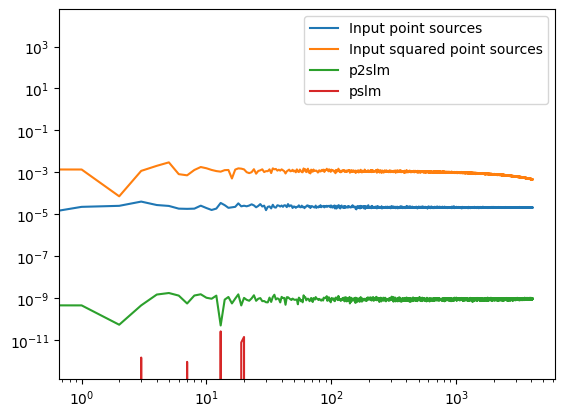

In [384]:
plt.loglog(hp.alm2cl(pslm), label = 'Input point sources')

plt.loglog(hp.alm2cl(ps2_lm), label = 'Input squared point sources')


plt.loglog(abs(hp.alm2cl(ps2_lm, alm_copy(slm, hp.Alm.getlmax(pslm.size)))), label = 'p2slm')

plt.loglog((hp.alm2cl(pslm, alm_copy(slm, hp.Alm.getlmax(pslm.size)))), label = 'pslm')

plt.legend()

In [53]:
totalmappa = pslm+tlm

total_cl = hp.alm2cl(totalmappa)
signal_cl = np.ones_like(total_cl)

nside = 2048
mf = F.matched_filter(input_map_alm = totalmappa, total_cl = total_cl, signal_cl = signal_cl, nside = nside)

In [59]:
fgpower = hp.alm2cl(pslm)
np.savetxt("fgpower.txt", fgpower)

/Users/omard/Documents/projects/fgcmblensing/iterativeforegroundsfullsky/itfgs/notebooks


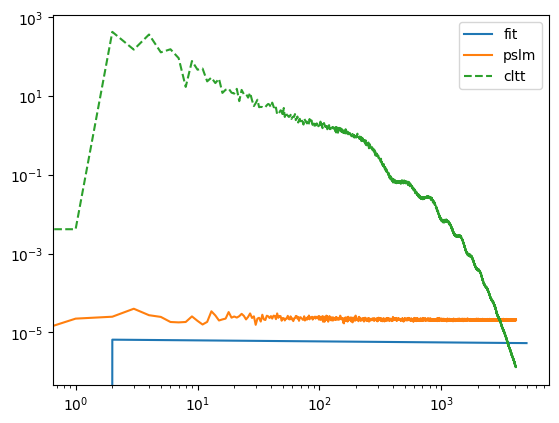

In [375]:
#fit fgpower with some constant

fit = np.loadtxt("fgpower.txt")
fit = fit[2:1000]
fit = np.polyfit(np.log(np.arange(2,1000)), np.log(fit), 1)
fit = np.exp(np.polyval(fit, np.log(np.arange(2,5000))))
fit = np.concatenate((np.zeros(2), fit))
plt.loglog(fit, label = 'fit')
plt.loglog(hp.alm2cl(pslm), label = 'pslm')
plt.loglog(hp.alm2cl(tlm), label = 'cltt', ls = "--")
plt.legend()

np.savetxt("fit.txt", fit)
!pwd

In [117]:
len(fit)

5000

In [54]:
threshold = 5
SN_map = abs(mf) / np.std(mf)
mask =  np.where(SN_map > threshold, 0, 1)

In [55]:
positions = hp.pix2vec(nside, np.where(mask == 0))

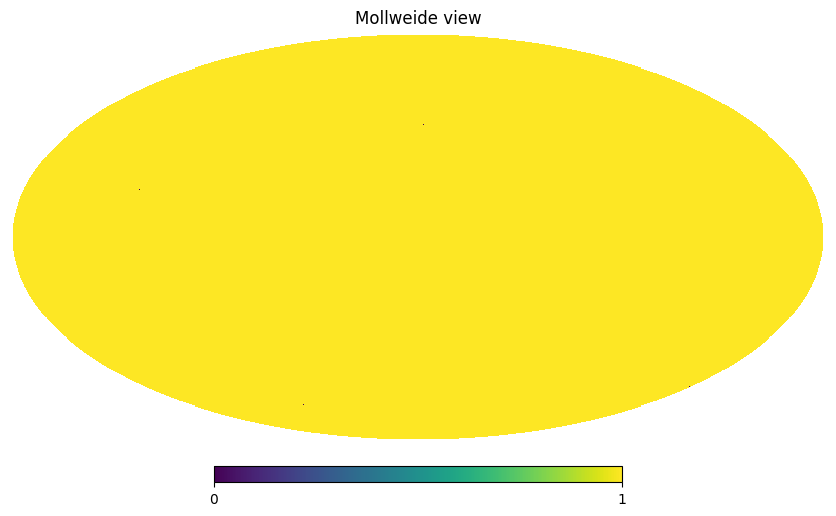

In [56]:
radius = 5 #in arcmin
radius = np.radians(radius/60)

pixvalues = [hp.query_disc(nside, (a, b, c), radius) for a, b, c in zip(positions[0][0], positions[1][0], positions[2][0])]
pixvalues = np.unique(np.concatenate(pixvalues))

newmask = np.ones_like(mask)

for pix in pixvalues:
    newmask[pix] = 0

hp.mollview(newmask)

In [40]:
pmap = hp.alm2map(pslm, nside = nside)

In [41]:
pmapnew = pmap*newmask
pslmnew = hp.map2alm(pmapnew, lmax = lmax)

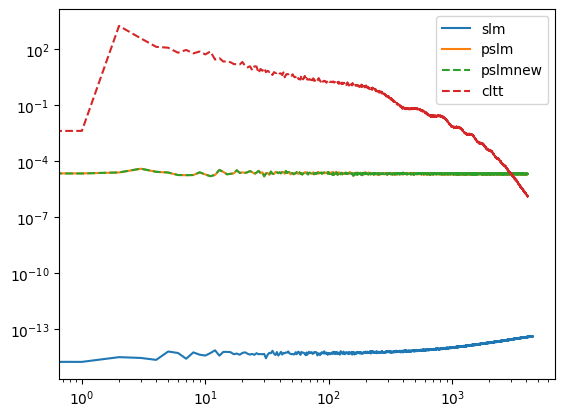

In [42]:
plt.loglog(hp.alm2cl(slm), label = 'slm')
plt.loglog(hp.alm2cl(pslm), label = 'pslm')
plt.loglog(hp.alm2cl(pslmnew), label = 'pslmnew', ls = "--")
plt.loglog(hp.alm2cl(tlm), label = 'cltt', ls = "--")
plt.legend()

In [57]:
plmin = hp.read_alm("/Users/omard/Downloads/SCRATCHFOLDER/n32/S4WebskyWebskyBorn/cmbs/plm_in_1_lmax5120.fits")
plmin = alm_copy(plmin, lmax = lmax)

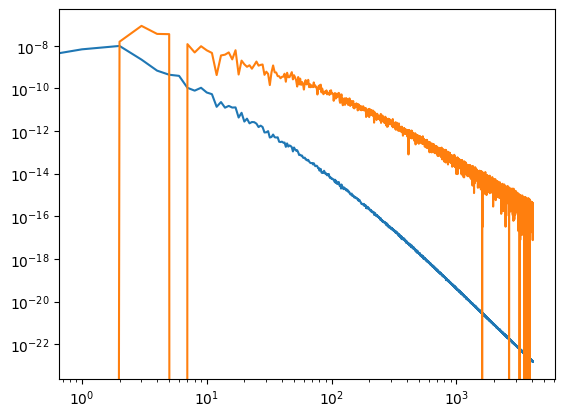

In [58]:
plt.loglog(hp.alm2cl(plmin), label = 'plmin')
plt.loglog(hp.alm2cl(pslm, plmin), label = 'pslm')


## Apply plancklens QE

In [69]:
import scipy
#from scipy import signal


def bin_theory(l, cl, bin_edges):
    sums = scipy.stats.binned_statistic(l, l, statistic="sum", bins=bin_edges)
    cl = scipy.stats.binned_statistic(l, l*cl, statistic="sum", bins=bin_edges)
    cl = cl[0] / sums[0]
    return cl


bin_edges = np.arange(10, 4500, 50)

els = bin_edges[:-1] + np.diff(bin_edges)/2

In [ ]:
from plancklens import utils

plmin = hp.read_alm("/Users/omard/Downloads/SCRATCHFOLDER/n32/S4WebskyWebskyBornForegrounds/cmbs/plm_in_0_lmax5120.fits")
plmin = utils.alm_copy(plmin, lmax=4500)

In [7]:
lmax = hp.Alm.getlmax(plmin.size)
ls = np.arange(lmax + 1)
factor = ls * (ls + 1) / 2
klmin = hp.almxfl(plmin, factor)
kin = hp.alm2map(klmin, 2048)

In [390]:
#pin = hp.alm2map(plmin, nside = 2048)

In [24]:
probability = np.random.poisson(abs(kin)*0.05)

In [25]:
positions = np.where(probability > 0)[0]

In [26]:
len(positions)

147692

In [69]:
mappa = np.zeros(hp.nside2npix(2048))

amplitudes = np.random.poisson(50, len(positions))

mappa[positions] = amplitudes


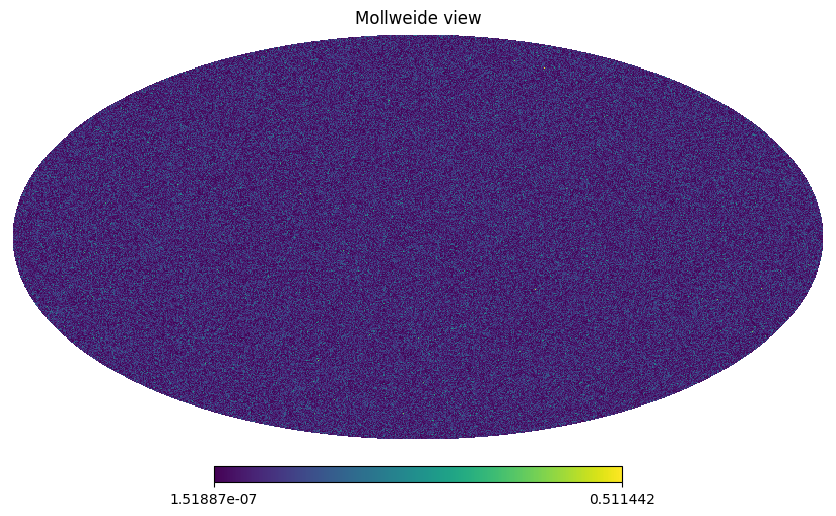

In [70]:
hp.mollview(abs(kin))

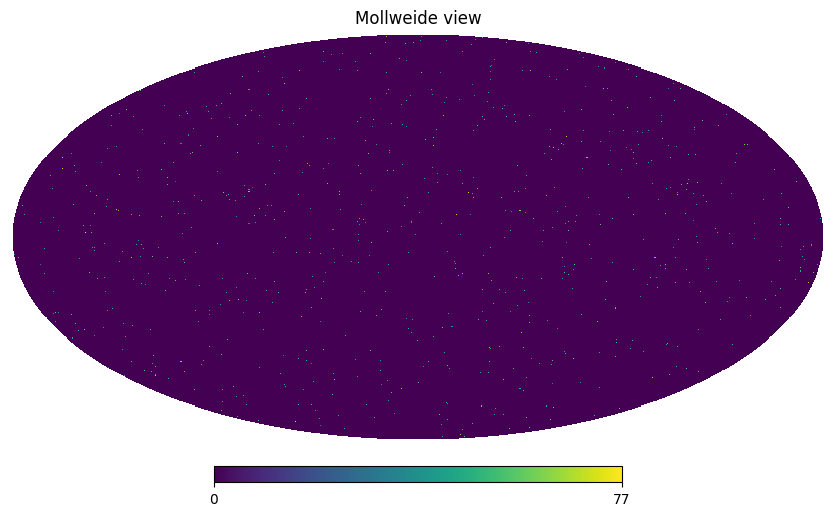

In [71]:
hp.mollview(mappa)

In [72]:
almmappa = hp.map2alm(mappa, lmax = 4500)

In [73]:
crosscorr = hp.alm2cl(almmappa, plmin)


In [74]:
auto = hp.alm2cl(almmappa)


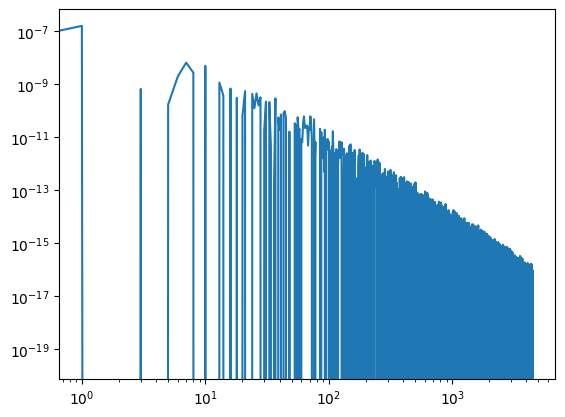

In [75]:
#plt.loglog(abs(crosscorr))
plt.loglog(crosscorr)

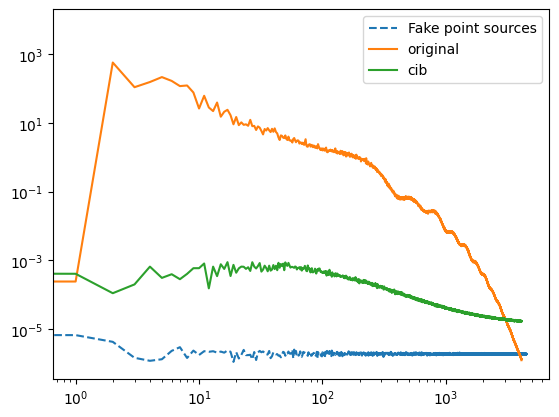

In [79]:
plt.loglog(auto, ls = '--', label = "Fake point sources")
#plt.loglog(cls, label = "independent fake point sources")
plt.loglog(clsoriginal, label = 'original')
plt.loglog(clcib, label = 'cib')
plt.legend()

In [77]:
idx = 0
hp.write_map(f"/Users/omard/Downloads/SCRATCHFOLDER/SKYSIMS/WEBSKYSIMS/fake_ps_mappa_{idx}.fits", mappa)

setting the output map dtype to [dtype('float64')]


In [87]:
hp.write_map(f"/Users/omard/Downloads/SCRATCHFOLDER/SKYSIMS/WEBSKYSIMS/randomized_fake_ps_mappa_{idx}.fits", hp.alm2map(randomizing_fg(almmappa), nside = 2048))

setting the output map dtype to [dtype('float64')]


In [100]:
almmappa = hp.map2alm(mappa, lmax = 4096)

In [101]:
totaltlm = tlm+almmappa

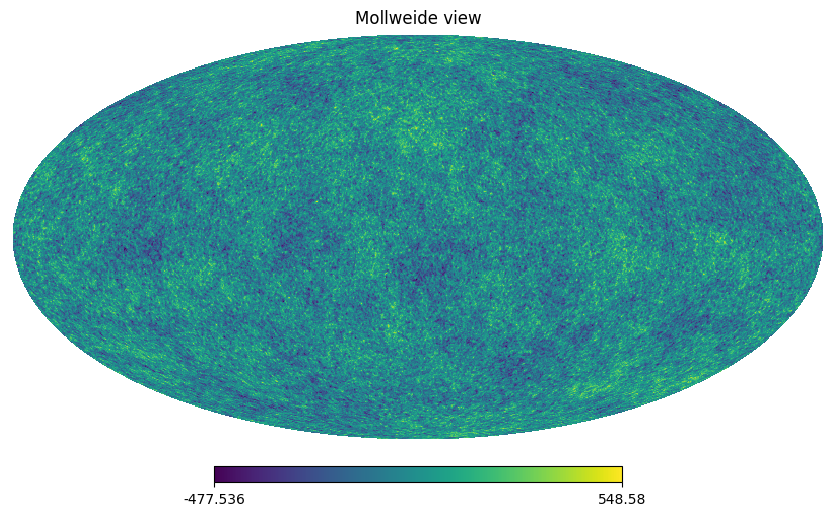

In [114]:
hp.mollview(tmap)

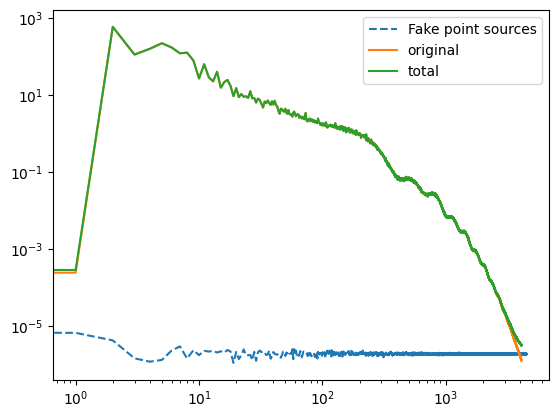

In [102]:
plt.loglog(auto, ls = '--', label = "Fake point sources")
#plt.loglog(cls, label = "independent fake point sources")
plt.loglog(clsoriginal, label = 'original')
plt.loglog(hp.alm2cl(totaltlm), label = 'total')
plt.legend()

In [115]:
prefiltered = hp.almxfl(totaltlm, 1/hp.alm2cl(totaltlm))

In [116]:
signal = np.ones_like(hp.alm2cl(totaltlm))

In [117]:
filtered_alm = hp.almxfl(prefiltered, signal)

In [118]:
filtered = hp.alm2map(filtered_alm, nside = nside)

In [123]:
SN_map = abs(filtered) / np.std(filtered)

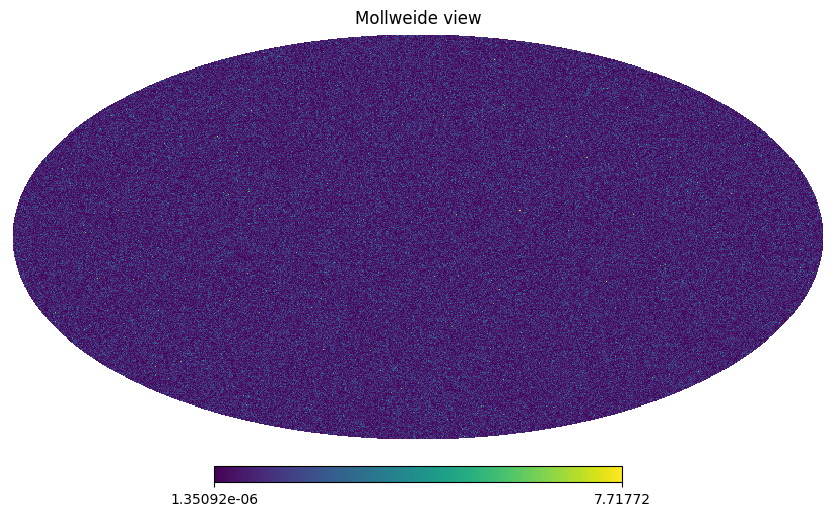

In [124]:
hp.mollview(SN_map)

In [125]:
snr_thr = 5
where = abs(SN_map)>snr_thr
mask = SN_map*0.+1.
mask[where] = 0.

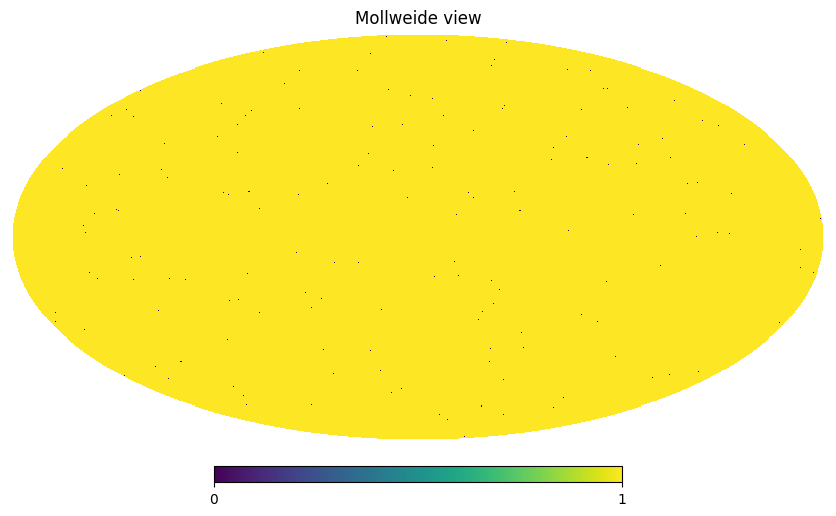

In [126]:
hp.mollview(mask)

In [135]:
almmappanew = hp.map2alm(mappa*mask, lmax = 4500)
crosscorrnew = hp.alm2cl(almmappanew, plmin)

In [140]:
autonew = hp.alm2cl(almmappanew)
auto = hp.alm2cl(almmappa)

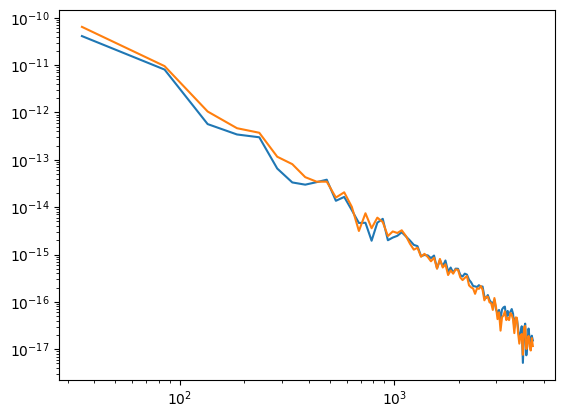

In [139]:
plt.loglog(els, bin_theory(ls, crosscorr, bin_edges))
plt.loglog(els, bin_theory(ls, crosscorrnew, bin_edges))

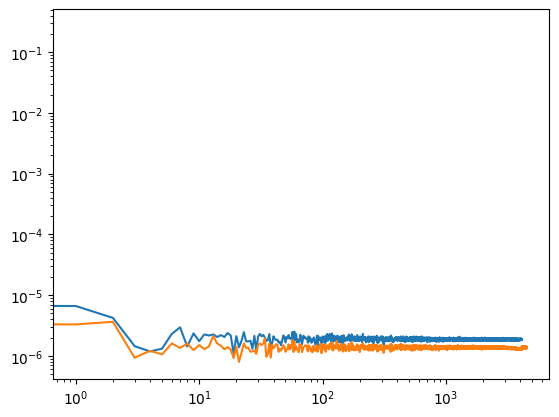

In [145]:
plt.loglog(auto)
plt.loglog(autonew/np.mean(mask**2.))

In [133]:
np.mean(mask)

0.9993230501810709

In [127]:
beam_fwhm_deg = 5/60 # 5 arcmin
m = hp.smoothing(mask, fwhm = np.radians(beam_fwhm_deg))


In [132]:
np.mean(m)

0.9993230495249356

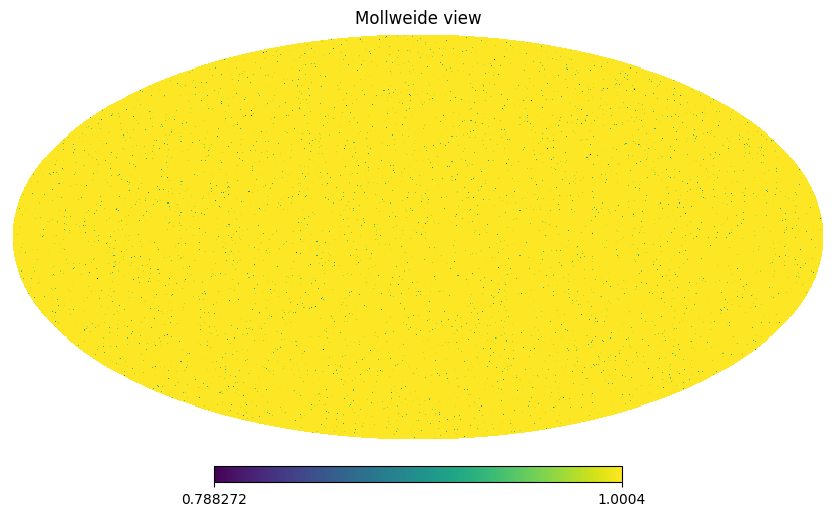

In [128]:
hp.mollview(m)

In [221]:
import healpy as hp
import numpy as np
import matplotlib.pyplot as plt

In [222]:
import scipy
#from scipy import signal


def bin_theory(l, cl, bin_edges):
    sums = scipy.stats.binned_statistic(l, l, statistic="sum", bins=bin_edges)
    cl = scipy.stats.binned_statistic(l, l*cl, statistic="sum", bins=bin_edges)
    cl = cl[0] / sums[0]
    return cl


bin_edges = np.arange(10, 4500, 200)

els = bin_edges[:-1] + np.diff(bin_edges)/2

In [223]:
from plancklens import utils

plmin = hp.read_alm("/Users/omard/Downloads/SCRATCHFOLDER/n32/S4WebskyWebskyBorn/cmbs/plm_in_0_lmax5120.fits")
plmin = utils.alm_copy(plmin, lmax=4500)

In [224]:
plmingauss = hp.read_alm("/Users/omard/Downloads/SCRATCHFOLDER/n32/S4WebskyWebskyBornGauss/cmbs/plm_in_1_lmax5120.fits")
plmingauss = utils.alm_copy(plmingauss, lmax=4500)

In [225]:
inin = hp.alm2cl(plmin)

In [226]:
inin_gauss = hp.alm2cl(plmingauss)

In [240]:
directory = "/Users/omard/Downloads/SCRATCHFOLDER/n32/S4WebskyWebskyBornForegrounds"
get_specific_dir = lambda s, k, id: directory+s+f"/lenscarfrecs/{k}_sim{id:04}"
specific_name = ["", "Rand", "Gauss"]
ks = ["ptt"]#, "ptt_bh_s"]
vs = ["", "", "", ""]
cases = ["", "rand", "gauss"]
ids = [1]

In [248]:
from delensalot.core.iterator import statics

In [299]:
def load_rec(direc, key, itermax):
    if "bh" in key:
        itermax = 1 if itermax > 0 else 0
    return np.sum([np.load(direc+f"/hessian/rlm_sn_{i}_p.npy") for i in range(itermax)], axis = 0) if itermax > 0 else 0

In [323]:
def load_rec(direc, key, itermax):
    return statics.rec.load_plms(direc, range(itermax+1))[-1]

In [324]:
maximumiter = 8

In [325]:
results = {}

for k in ks:
    temp = {}
    for case, specific in zip(cases, specific_name):
        tempiters = {}
        for itermax in range(maximumiter+1):
            mean = 0
            meanc = 0
            for id in ids:
                print(get_specific_dir(specific, k, id)+"/phi_plm_it000.npy")
                rec = np.load(get_specific_dir(specific, k, id)+"/phi_plm_it000.npy")
                rec1 = load_rec(get_specific_dir(specific, k, id), k, itermax)
                rec = rec1
                mean += hp.alm2cl(rec, rec)
                pin = plmin if case != "gauss" else plmingauss
                meanc += hp.alm2cl(rec, pin)

            mean /= len(ids)
            meanc /= len(ids)
            tempiters[itermax] = np.c_[mean, meanc]
        temp[case] = tempiters
    results[k] = temp

/Users/omard/Downloads/SCRATCHFOLDER/n32/S4WebskyWebskyBornForegrounds/lenscarfrecs/ptt_sim0001/phi_plm_it000.npy
/Users/omard/Downloads/SCRATCHFOLDER/n32/S4WebskyWebskyBornForegrounds/lenscarfrecs/ptt_sim0001/phi_plm_it000.npy
/Users/omard/Downloads/SCRATCHFOLDER/n32/S4WebskyWebskyBornForegrounds/lenscarfrecs/ptt_sim0001/phi_plm_it000.npy
/Users/omard/Downloads/SCRATCHFOLDER/n32/S4WebskyWebskyBornForegrounds/lenscarfrecs/ptt_sim0001/phi_plm_it000.npy
/Users/omard/Downloads/SCRATCHFOLDER/n32/S4WebskyWebskyBornForegrounds/lenscarfrecs/ptt_sim0001/phi_plm_it000.npy
/Users/omard/Downloads/SCRATCHFOLDER/n32/S4WebskyWebskyBornForegrounds/lenscarfrecs/ptt_sim0001/phi_plm_it000.npy
/Users/omard/Downloads/SCRATCHFOLDER/n32/S4WebskyWebskyBornForegrounds/lenscarfrecs/ptt_sim0001/phi_plm_it000.npy
/Users/omard/Downloads/SCRATCHFOLDER/n32/S4WebskyWebskyBornForegrounds/lenscarfrecs/ptt_sim0001/phi_plm_it000.npy
/Users/omard/Downloads/SCRATCHFOLDER/n32/S4WebskyWebskyBornForegrounds/lenscarfrecs/ptt_

In [326]:
results.keys()

dict_keys(['ptt'])

In [327]:
results["ptt"]["gauss"].keys()

dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8])

In [328]:
ls = np.arange(0, len(inin))

In [329]:
norms = {}
for k, v in results.items():
    g = v["gauss"]
    temp = []
    for it, vit in g.items():
        cg = vit[:, 1]
        temp += [np.nan_to_num(cg/inin_gauss)]
    norms[k] = temp


/var/folders/5s/mpby42n15_ng7rv494cv19tw0000gn/T/ipykernel_4748/636768776.py:7: RuntimeWarning: invalid value encountered in divide
  temp += [np.nan_to_num(cg/inin_gauss)]


In [330]:
from scipy import stats

In [331]:
#norms = np.load("/Users/omard/Documents/projects/fgcmblensing/iterativeforegroundsfullsky/itfgs/notebooks/norms_gauss_born_gaussian.npy")

In [332]:
lnorm = np.arange(norms["ptt"][0].shape[0])

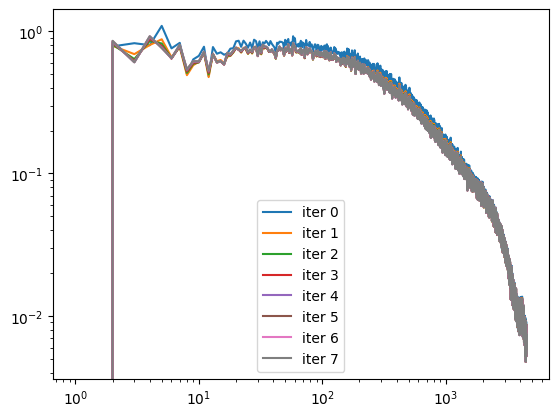

In [333]:
for kk in range(itermax):
    plt.loglog(norms["ptt"][kk], label = f"iter {kk}")
plt.legend()

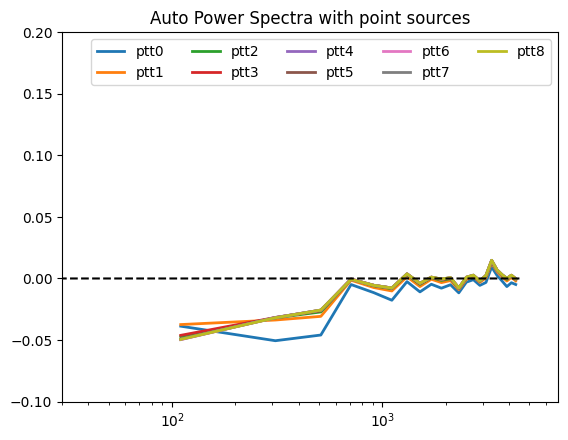

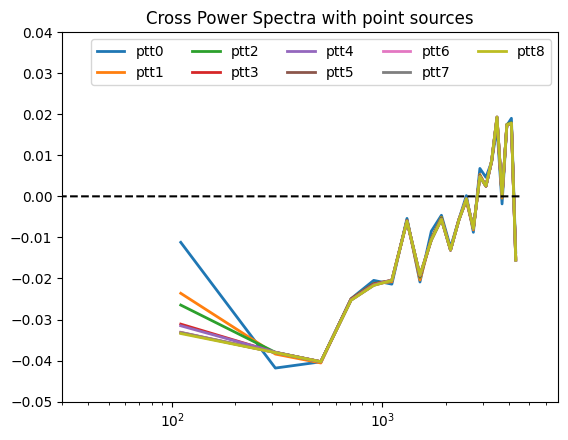

In [309]:
titles = ["Auto", "Cross"]
ylims = [(-0.1, 0.2), (-0.05, 0.04)]
for i in range(2):
    plt.title(f"{titles[i]} Power Spectra with point sources")

    A, B, C = cases

    for k, v in results.items():
        for j in range(itermax+1):
            diff = v[A][j]-v[B][j] #NG-RandNG
            diff_binned = bin_theory(ls, diff[:, i], bin_edges)
            inin_binned = bin_theory(ls, inin, bin_edges)
            #p = plt.plot(diff[:, i]/inin, alpha = 0.5)
            label = k+str(j)
            lines = "--" if "bh" in k else "-"
            norm = np.interp(els, lnorm, norms[k][j])
            #norm = norms[k][j]
            if not ("bh" in k and j > 1):
                plt.plot(els, diff_binned/inin_binned/norm, lw = "2", label = label, ls = lines)#, color = p[0].get_color())#, color = p[0].get_color(), label = k)
        plt.plot(ls, np.ones_like(ls)*0., ls = "--", color = "k")
    plt.ylim(*ylims[i])
    plt.xscale("log")
    plt.xlim(30)
    plt.legend(ncol = 5)
    plt.show()